### 29 May, 2019
### Analyse the NNs trained using train_NNs.py
####  Works with Python 2.7 and Tensorflow 1.3.0 (CPU version)

In [1]:
# Import all the required packages

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import tensorflow as tf
%pylab inline
import scipy.misc
import scipy
sess = tf.InteractiveSession()
import seaborn as sns
from scipy.ndimage.interpolation import zoom
import time
from random import shuffle
import os
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial.distance import squareform
import time
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Function definitions

def create_permuted_mnist(dat,nums,ord_create=True,filename='order_mat_perm_mnist.npy'): 
# Outputs a dictionary of permuted datasets
# feed the mnist struct to dat, nums is the number of permuted instances to be created, ord_create=True implies a new set of permutations
# are generated and stored in 'filename'. If False, the file in 'filename' is read
  if ord_create:
    order_mat = np.zeros([nums,784])
    for i in range(nums):
      if i == 0:
        order_mat[i,:] = np.arange(784)
      else:
        order_mat[i,:] = np.arange(784)
        shuffle(order_mat[i,:])
    np.save(filename,order_mat)
  else:
    if os.path.exists(filename):
      order_mat = np.load(filename)
    else:
      print('File does not exist!\n')
  dict_mnist = {}
  dict_inst = {}
  dict_inst.update({'train_images':dat.train.images.copy(),'train_labels':dat.train.labels.copy(),'val_images':dat.validation.images.copy(),
    'val_labels':dat.validation.labels.copy(),'test_images':dat.test.images.copy(),'test_labels':dat.test.labels.copy()})
  dict_inst.update({'order':order_mat[0,:]})
  dict_mnist.update({str(0):dict_inst})
  for i in range(nums-1):
    inst_ord = order_mat[i+1,:].astype('int32')
    dict_inst = {}
    dict_inst.update({'order':inst_ord})
    dict_inst.update({'train_images':dat.train.images[:,inst_ord].copy(),'train_labels':dat.train.labels.copy(),
      'val_images':dat.validation.images[:,inst_ord].copy(), 'val_labels':dat.validation.labels.copy(),
      'test_images':dat.test.images[:,inst_ord].copy(),'test_labels':dat.test.labels.copy()})
    dict_mnist.update({str(i+1):dict_inst})
  return dict_mnist#,order_mat

def get_batch(bat_sz,modh,cat,lay,nums,dat,operatn): 
# Outputs a batch of size bat_sz with half samples with positive matches between cues and objects in the images.
# input cat_sel in cat, input mode_h in modh, bat_sz should be even, input lay_sel in lay,
# input number of permutations in nums, input the dataset as dat, input train/val/test as operatn
  x = np.zeros([bat_sz,784])
  y = np.zeros([bat_sz,2])
  yc1 = np.zeros([bat_sz,10*nums+1])
  yc2 = np.zeros([bat_sz,10*nums+1])
  str_images_h = operatn+'_images'
  str_labels_h = operatn+'_labels'
  if modh == 1:
    dat_h = np.int(np.floor((cat-1)*1./10*1.))
    dat_sel_h = np.zeros(bat_sz)
    dat_sel_h[0:bat_sz/2] = dat_h
    dat_sel_h[bat_sz/2:] = np.random.randint(0,nums,bat_sz/2)
    ex_sel_h = np.where(np.argmax(dat[str(np.int(dat_h))][str_labels_h],1)==cat-1)[0]
    shuffle(ex_sel_h)
    x[:bat_sz/2,:] = dat[str(np.int(dat_h))][str_images_h][ex_sel_h[:bat_sz/2],:]
    y[:bat_sz/2,0] = 1.
    for i in range(bat_sz/2):
      ex_sel_inst = np.random.randint(np.shape(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h])[0])
      if dat_sel_h[bat_sz/2+i] == dat_h:
        while np.argmax(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h][ex_sel_inst,:]) == cat-1:
          ex_sel_inst = np.random.randint(np.shape(dat[str(np.int(dat_h))][str_labels_h])[0])
      x[bat_sz/2+i,:] = dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_images_h][ex_sel_inst,:]
    y[bat_sz/2:,1] = 1.
    yc1[:,-1] = 1.
    yc2[:,-1] = 1.
  elif (modh == 2) or (modh == 3):
    dat_sel_h = np.random.randint(0,nums,bat_sz)
    for i in range(bat_sz/2):
      ex_sel_inst = np.random.randint(np.shape(dat[str(np.int(dat_sel_h[i]))][str_labels_h])[0])
      x[i,:] = dat[str(np.int(dat_sel_h[i]))][str_images_h][ex_sel_inst,:]
      y[i,0] = 1.
      if lay == 1:
        yc1[i,np.int(dat_sel_h[i])*10+np.argmax(dat[str(np.int(dat_sel_h[i]))][str_labels_h][ex_sel_inst,:])] = 1.
        yc2[i,-1] = 1.
      elif lay == 2:
        yc1[i,-1] = 1.
        yc2[i,np.int(dat_sel_h[i])*10+np.argmax(dat[str(np.int(dat_sel_h[i]))][str_labels_h][ex_sel_inst,:])] = 1.
      elif lay == 3:
        yc1[i,np.int(dat_sel_h[i])*10+np.argmax(dat[str(np.int(dat_sel_h[i]))][str_labels_h][ex_sel_inst,:])] = 1.
        yc2[i,np.int(dat_sel_h[i])*10+np.argmax(dat[str(np.int(dat_sel_h[i]))][str_labels_h][ex_sel_inst,:])] = 1.
      elif lay == 4:
        yc1[i,np.int(dat_sel_h[i])*10+np.argmax(dat[str(np.int(dat_sel_h[i]))][str_labels_h][ex_sel_inst,:])] = 1.
        yc1[i,-1] = 1.
        yc2[i,np.int(dat_sel_h[i])*10+np.argmax(dat[str(np.int(dat_sel_h[i]))][str_labels_h][ex_sel_inst,:])] = 1.
    for i in range(bat_sz/2):
      ex_sel_inst = np.random.randint(np.shape(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h])[0])
      x[bat_sz/2+i,:] = dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_images_h][ex_sel_inst,:]
      y[bat_sz/2+i,1] = 1.
      if lay == 1:
        pos_sel_h = np.random.randint(10*nums)
        while pos_sel_h == np.int(dat_sel_h[bat_sz/2+i])*10+np.argmax(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h][ex_sel_inst,:]):
          pos_sel_h = np.random.randint(10*nums)
        yc1[bat_sz/2+i,pos_sel_h] = 1.
        yc2[bat_sz/2+i,-1] = 1.
      elif lay == 2:
        pos_sel_h = np.random.randint(10*nums)
        while pos_sel_h == np.int(dat_sel_h[bat_sz/2+i])*10+np.argmax(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h][ex_sel_inst,:]):
          pos_sel_h = np.random.randint(10*nums)
        yc2[bat_sz/2+i,pos_sel_h] = 1.
        yc1[bat_sz/2+i,-1] = 1.
      elif lay == 3:
        pos_sel_h = np.random.randint(10*nums)
        while pos_sel_h == np.int(dat_sel_h[bat_sz/2+i])*10+np.argmax(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h][ex_sel_inst,:]):
          pos_sel_h = np.random.randint(10*nums)
        yc2[bat_sz/2+i,pos_sel_h] = 1.
        yc1[bat_sz/2+i,pos_sel_h] = 1.
      elif lay == 4:
        pos_sel_h = np.random.randint(10*nums)
        while pos_sel_h == np.int(dat_sel_h[bat_sz/2+i])*10+np.argmax(dat[str(np.int(dat_sel_h[bat_sz/2+i]))][str_labels_h][ex_sel_inst,:]):
          pos_sel_h = np.random.randint(10*nums)
        yc2[bat_sz/2+i,pos_sel_h] = 1.
        yc1[bat_sz/2+i,-1] = 1.
        yc1[bat_sz/2+i,pos_sel_h] = 1.
  return x,y,yc1,yc2

def mod_images_noise(x,noiser=0.4): # add uniform random noise to images
  x1 = 0.*(x.copy())
  x1 = (1.-noiser)*x.copy() + noiser*np.random.random([np.shape(x)[0],np.shape(x)[1]])
  return x1

def mod_images_normal(x,zoomer=24./28.,noiser=0.2): # add uniform random noise and translation (with scaling) to images
  x1 = x.copy()
  x1 = 0.*x1
  for i in range(np.shape(x)[0]):
    dum1 = zoom(np.reshape(x[i,:],[28,28]),zoomer)
    dum2 = 0.*np.reshape(x[i,:],[28,28])
    dum_x = np.random.randint(np.int(np.floor(28.-zoomer*28.)))
    dum_y = np.random.randint(np.int(np.floor(28.-zoomer*28.)))
    dum2[dum_x:dum_x+np.int(np.floor(zoomer*28.)),dum_y:dum_y+np.int(np.floor(zoomer*28.))] = dum1
    x1[i,:] = (1.-noiser)*np.reshape(dum2,[1,784]) + noiser*np.random.random([1,784])
  return x1

def weight_variable_fc(shape,name):
  initial = tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer()) 
  return initial

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [3]:
# Configuring the NN variant

mode_h = 2 # 1 is train on a specified category, 2 is train on all categories with learned modulations, 3 is train on all categories with random modulations
cat_sel = 5 # select category for when mode_h == 1
lay_sel = 3 # 1 for L1->L2 modulation, 2 for L2->L3 modulation, 3 for both L1->L2 & L2->L3 modulation, 4 for L1->L2 on L2->L3 (pre-trained)
n_hl1 = 32 # no. of neurons in L2
n_hl2 = 2 # no. of neurons in L3
n_perms = 50 # how many mnist permutations to use (1/10 the number of total tasks)
train_dropout = 1.
g_train = 1. # gain multiplier - set to 0 if gain modulation shouldn't be used
b_train = 1. # bias multiplier - set to 0 if bias modulation shouldn't be used

str_data_loader = 'order_perms/order_mat_perm_mnist_'+str(n_perms)+'.npy'
perm_mnist = create_permuted_mnist(mnist,n_perms,False,str_data_loader) # set to False if an existing set is to be used
print('Dataset created')

Dataset created


In [4]:
# Creating the NN

x  = tf.placeholder(tf.float32, [None, 28*28], name='x')
y_ = tf.placeholder(tf.float32, [None, n_hl2],  name='y_')
y_c1 = tf.placeholder(tf.float32, [None, 10*n_perms+1],  name='y_c1') # 10*n_perms cats, 1 general (to be used when lay_sel is 1 or 2)
y_c2 = tf.placeholder(tf.float32, [None, 10*n_perms+1],  name='y_c2') # 10*n_perms cats, 1 general (to be used when lay_sel is 1 or 2)
keep_prob  = tf.placeholder(tf.float32)
g_flag = tf.placeholder(tf.float32)
b_flag = tf.placeholder(tf.float32)

W_fc1 = weight_variable_fc([28*28, n_hl1],'W_fc1')
b_fc1 = bias_variable([n_hl1])
W_fc2 = weight_variable_fc([n_hl1, n_hl2],'W_fc2')
b_fc2 = bias_variable([n_hl2])
W_fc1_b = weight_variable_fc([10*n_perms+1, n_hl1],'W_fc1_b')
W_x_g = weight_variable_fc([10*n_perms+1, 28*28],'W_x_g')
W_fc2_b = weight_variable_fc([10*n_perms+1, n_hl2],'W_fc2_b')
W_fc1_g = weight_variable_fc([10*n_perms+1, n_hl1],'W_fc1_g')

saver = tf.train.Saver({"W_fc1": W_fc1, "b_fc1": b_fc1, "W_fc2": W_fc2, "b_fc2": b_fc2,
                        "W_x_g": W_x_g, "W_fc1_b": W_fc1_b, "W_fc1_g": W_fc1_g, "W_fc2_b": W_fc2_b})
if mode_h == 1:
    str_h = "./models_new/perm_mnist_" + str(n_perms) + "_hl" + str(n_hl1) + "_cat" + str(cat_sel) + "_base.cpkt"
elif mode_h == 2:
    str_h = "./models_new/perm_mnist_" + str(n_perms) + "_hl" + str(n_hl1) + "_allcat" + "_fbcase_" + str(lay_sel) + "_bg_" + str(b_train) + str(g_train) + ".cpkt"
elif mode_h == 3:
    str_h = "./models_new/perm_mnist_" + str(n_perms) + "_hl" + str(n_hl1) + "_allcat" + "_fbcase_rand_" + str(lay_sel) + "_bg_" + str(b_train) + str(g_train) + ".cpkt"
saver.restore(sess,str_h)
    
x_mod = tf.multiply(x,1.+g_flag*g_train*tf.matmul(y_c1, W_x_g))
h_fc1 = tf.multiply(tf.nn.relu(tf.matmul(x_mod, W_fc1) + tf.multiply(1.+b_flag*b_train*tf.matmul(y_c1, W_fc1_b), b_fc1)),1.+g_flag*g_train*tf.matmul(y_c2, W_fc1_g))
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + tf.multiply(1.+b_flag*b_train*tf.matmul(y_c2, W_fc2_b), b_fc2), name = 'y')

INFO:tensorflow:Restoring parameters from ./models_new/perm_mnist_50_hl32_allcat_fbcase_3_bg_1.01.0.cpkt


In [5]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(y,1e-10,1.0)), reduction_indices=[1]))
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Assessing the NN - performance and dependence on various internal factors

n_reps_h = 10
acc_vec_h = np.zeros([n_reps_h,5])
for i in range(n_reps_h):
    batch_xst, batch_yst, batch_ystc1, batch_ystc2 = get_batch(10000,mode_h,cat_sel,lay_sel,n_perms,perm_mnist,'test')
    batch_xst = mod_images_normal(batch_xst)
    acc_vec_h[i,0] = sess.run(accuracy, feed_dict={b_flag: 1., g_flag: 1., x: batch_xst,
                                                   y_: batch_yst, y_c1: batch_ystc1, y_c2: batch_ystc2,
                                                   keep_prob: 1.})
    acc_vec_h[i,1] = sess.run(accuracy, feed_dict={b_flag: 1., g_flag: 1., x: batch_xst, y_: batch_yst,
                                                   y_c1: batch_ystc1, y_c2: 0.*batch_ystc2, keep_prob: 1.})
    acc_vec_h[i,2] = sess.run(accuracy, feed_dict={b_flag: 1., g_flag: 1., x: batch_xst, y_: batch_yst,
                                                   y_c1: 0.*batch_ystc1, y_c2: batch_ystc2, keep_prob: 1.})
    acc_vec_h[i,3] = sess.run(accuracy, feed_dict={b_flag: 1., g_flag: 0., x: batch_xst, y_: batch_yst,
                                                   y_c1: batch_ystc1, y_c2: batch_ystc2, keep_prob: 1.})
    acc_vec_h[i,4] = sess.run(accuracy, feed_dict={b_flag: 0., g_flag: 1., x: batch_xst, y_: batch_yst,
                                                   y_c1: batch_ystc1, y_c2: batch_ystc2, keep_prob: 1.})
print('n_hl1', n_hl1)
print('n_perms', n_perms)
print('lay_condl', lay_sel)
print('Test_acc_bg: mean - ',np.mean(acc_vec_h[:,0]), ' , std - ' ,np.std(acc_vec_h[:,0]))
print('Test_acc_bg_L1->L2_only: mean - ',np.mean(acc_vec_h[:,1]), ' , std - ' ,np.std(acc_vec_h[:,1]))
print('Test_acc_bg_L2->L3_only: mean - ',np.mean(acc_vec_h[:,2]), ' , std - ' ,np.std(acc_vec_h[:,2]))
print('Test_acc_b: mean - ',np.mean(acc_vec_h[:,3]), ' , std - ' ,np.std(acc_vec_h[:,3]))
print('Test_perf_loss_g:',(np.mean(acc_vec_h[:,0]) - np.mean(acc_vec_h[:,3]))/np.mean(acc_vec_h[:,0]))
print('Test_acc_g: mean - ',np.mean(acc_vec_h[:,4]), ' , std - ' ,np.std(acc_vec_h[:,4]))
print('Test_perf_loss_b:',(np.mean(acc_vec_h[:,0]) - np.mean(acc_vec_h[:,4]))/np.mean(acc_vec_h[:,0]))

('n_hl1', 32)
('n_perms', 50)
('lay_condl', 3)
('Test_acc_bg: mean - ', 0.941210001707077, ' , std - ', 0.0021769032775068482)
('Test_acc_bg_L1->L2_only: mean - ', 0.9279199957847595, ' , std - ', 0.0015638512025106604)
('Test_acc_bg_L2->L3_only: mean - ', 0.5233300030231476, ' , std - ', 0.0024099981884225857)
('Test_acc_b: mean - ', 0.5186500012874603, ' , std - ', 0.001844588857744612)
('Test_perf_loss_g:', 0.44895400564509264)
('Test_acc_g: mean - ', 0.884469997882843, ' , std - ', 0.0034968608422471575)
('Test_perf_loss_b:', 0.06028410633261912)


### As observed across NNs trained, gain modulation is more important than bias modulation in our scheme.

('g_x_inhibitory_prop: ', 0.019061224489795917)
('g_x_max: ', 2.7941172)
('g_x_min: ', -2.6601794)
('g_fc1_inhibitory_prop: ', 0.011125)
('g_fc1_max: ', 2.1848438)
('g_fc1_min: ', -2.5981832)
('b_fc1_max: ', 1.3160282)
('b_fc1_min: ', -1.3762105)
('b_fc2_max: ', 0.7898026)
('b_fc2_min: ', -0.8286998)


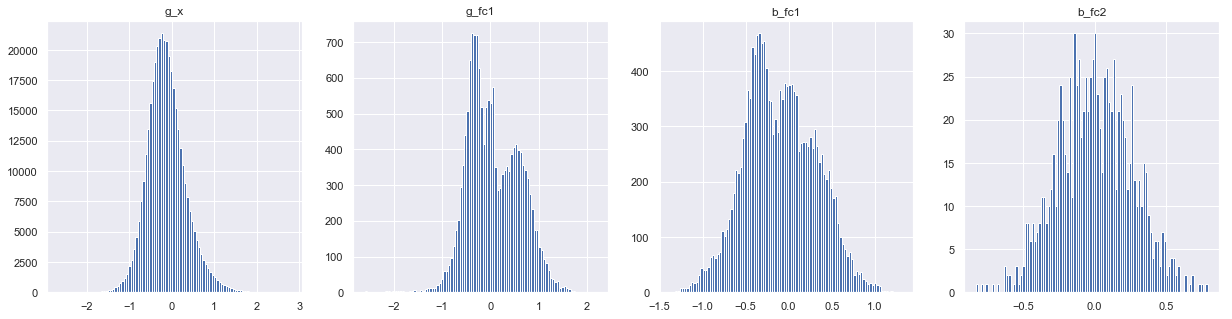

In [7]:
# Visualizing the extent of gain and bias modulations in the NN

w_g_x = W_x_g.eval()[:-1,:]
w_g_fc1 = W_fc1_g.eval()[:-1,:]
w_b_fc1 = W_fc1_b.eval()[:-1,:]
w_b_fc2 = W_fc2_b.eval()[:-1,:]
figure(figsize=(21,5))
subplot(1,4,1)
hist(np.reshape(w_g_x,(-1,1)),100);
title('g_x')
subplot(1,4,2)
hist(np.reshape(w_g_fc1,(-1,1)),100);
title('g_fc1')
subplot(1,4,3)
hist(np.reshape(w_b_fc1,(-1,1)),100);
title('b_fc1')
subplot(1,4,4)
hist(np.reshape(w_b_fc2,(-1,1)),100);
title('b_fc2')
print('g_x_inhibitory_prop: ',np.mean(np.reshape(w_g_x,(-1,1))<-1))
print('g_x_max: ',np.max(np.reshape(w_g_x,(-1,1))))
print('g_x_min: ',np.min(np.reshape(w_g_x,(-1,1))))
print('g_fc1_inhibitory_prop: ',np.mean(np.reshape(w_g_fc1,(-1,1))<-1))
print('g_fc1_max: ',np.max(np.reshape(w_g_fc1,(-1,1))))
print('g_fc1_min: ',np.min(np.reshape(w_g_fc1,(-1,1))))
print('b_fc1_max: ',np.max(np.reshape(w_b_fc1,(-1,1))))
print('b_fc1_min: ',np.min(np.reshape(w_b_fc1,(-1,1))))
print('b_fc2_max: ',np.max(np.reshape(w_b_fc2,(-1,1))))
print('b_fc2_min: ',np.min(np.reshape(w_b_fc2,(-1,1))))

('categ_W1_g: ', 0.47358580944597556)
('categ_W2_g: ', 0.4209936461585289)
('W2_w-b', -0.3434483527054524)
('categ_W1_b: ', 0.4687298302734068)
('categ_W2_b: ', 0.4687298302734068)


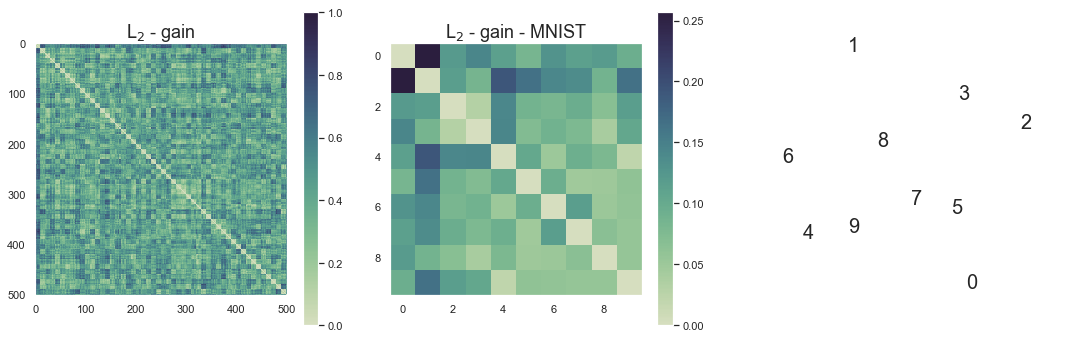

In [8]:
# Visualizing the similarities between task modulation vectors

map1 = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

embedding = MDS(n_components=2)

W1_g = pd.DataFrame(np.transpose(W_x_g.eval()))
W1_g_rsm = (1.-W1_g.corr('pearson'))/2
dum1_h = W1_g_rsm.values[:-1,:-1]
categ_W1_g = np.sum(dum1_h,1) - dum1_h.diagonal()
categ_W1_g = categ_W1_g/(10.*n_perms-1)
categ_W1_g_mean = np.mean(categ_W1_g)
print('categ_W1_g: ',categ_W1_g_mean)

dum1h = np.transpose(W_x_g.eval())
W1_g_mn = pd.DataFrame(dum1h[:,:10])
W1_g_mn_rsm = (1.-W1_g_mn.corr('pearson'))/2

W2_g = pd.DataFrame(np.transpose(W_fc1_g.eval()))
W2_g_rsm = (1.-W2_g.corr('pearson'))/2
dum1_h = W2_g_rsm.values[:-1,:-1]
categ_W2_g = np.sum(dum1_h,1) - dum1_h.diagonal()
categ_W2_g = categ_W2_g/(10.*n_perms-1)
categ_W2_g_mean = np.mean(categ_W2_g)
print('categ_W2_g: ',categ_W2_g_mean)

W2_full  = np.sum(dum1_h)
W2_within = 0.
for i in range(np.shape(dum1_h)[0]/10):
    W2_within = W2_within + np.sum(dum1_h[i*10:(i+1)*10,i*10:(i+1)*10])
W2_between = W2_full - W2_within
W2_between = W2_between/(n_perms*n_perms*100*1.-n_perms*1.*100)
W2_within = W2_within/(n_perms*1.*100)
print('W2_w-b',W2_within-W2_between)

dum1h = np.transpose(W_fc1_g.eval())
W2_g_mn = pd.DataFrame(dum1h[:,:10])
W2_g_mn_rsm = (1.-W2_g_mn.corr('pearson'))/2

W1_b = pd.DataFrame(np.transpose(W_fc1_b.eval()))
W1_b_rsm = (1.-W1_b.corr('pearson'))/2
dum1_h = W1_b_rsm.values[:-1,:-1]
categ_W1_b = np.sum(dum1_h,1) - dum1_h.diagonal()
categ_W1_b = categ_W1_b/(10.*n_perms-1)
categ_W1_b_mean = np.mean(categ_W1_b)
print('categ_W1_b: ',categ_W1_b_mean)

dum1h = np.transpose(W_fc1_b.eval())
W1_b_mn = pd.DataFrame(dum1h[:,:10])
W1_b_mn_rsm = (1.-W1_b_mn.corr('pearson'))/2

W2_b = pd.DataFrame(np.transpose(W_fc2_b.eval()))
W2_b_rsm = (1.-W2_b.corr('pearson'))/2
dum1_h = W2_b_rsm.values[:-1,:-1]
categ_W2_b = np.sum(dum1_h,1) - dum1_h.diagonal()
categ_W2_b = categ_W2_b/(10.*n_perms-1)
categ_W2_b_mean = np.mean(categ_W1_b)
print('categ_W2_b: ',categ_W2_b_mean)

dum1h = np.transpose(W_fc2_b.eval())
W2_b_mn = pd.DataFrame(dum1h[:,:10])
W2_b_mn_rsm = (1.-W2_b_mn.corr('pearson'))/2

figure(figsize=(15,5))
subplot(1,3,1)
imshow(W2_g_rsm,cmap=map1)
clim([0,1])
grid('off')
title('L$_2$ - gain',fontsize=18)
colorbar()
subplot(1,3,2)
imshow(W2_g_mn_rsm,cmap=map1)
grid('off')
title('L$_2$ - gain - MNIST',fontsize=18)
colorbar()
subplot(1,3,3)
dum1h = W_fc1_g.eval()
X_transformed = embedding.fit_transform(dum1h[:10,:])
plot(X_transformed[:,0]*1.2,X_transformed[:,1]*1.2,'.',markersize=0)
for i in np.arange(np.shape(X_transformed)[0]):
    text(X_transformed[i,0],X_transformed[i,1],str(i),fontsize=20)
grid('off')
axis('off')
tight_layout()
#plt.savefig('task_vectors_RDM.png', dpi = 300,bbox_inches='tight')

### This hierarchical structure between task modulations is essential, as if we deploy the same NN (with L2 having 32 neurons and 50 permutations of MNIST) with modulations randomly sampled from a normal distribution, the performance after modulating both L1->L2 and L2->L3 is ~ 80%, as opposed to ~93% with learned modulations!

('L2, PC1, var expl: ', 0.8751230755757229)
('L2, PC1, var expl: ', 0.506100179560866)
('avg_dissim-free,104 : ', 0.3647817766633544)
('avg_dissim-free,224 : ', 0.4189926812553746)
('avg_dissim-104, 104: ', 0.4602031826366783)
('avg_dissim-104, 224: ', 0.09996562936309783)
('avg_dissim-224, 104: ', 0.4602031826366783)
('avg_dissim-224, 224: ', 0.09996562936309783)


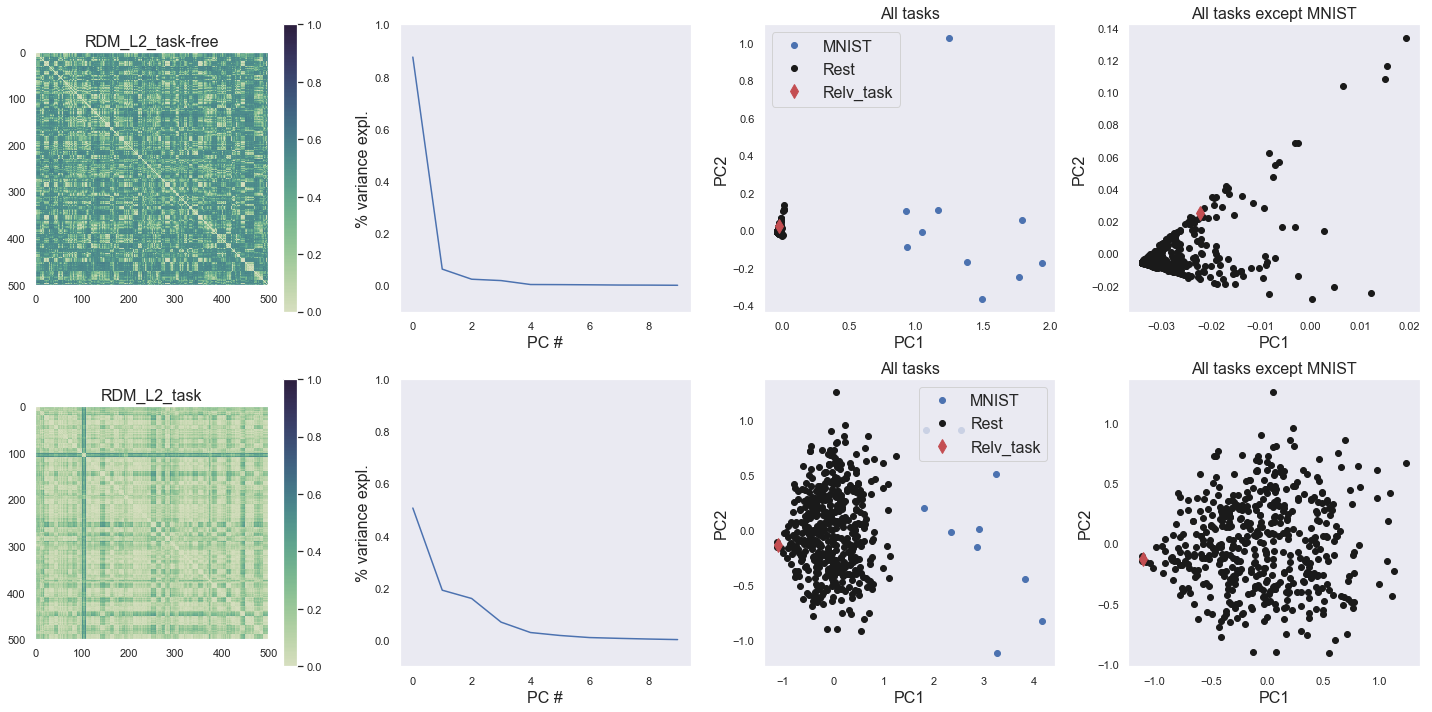

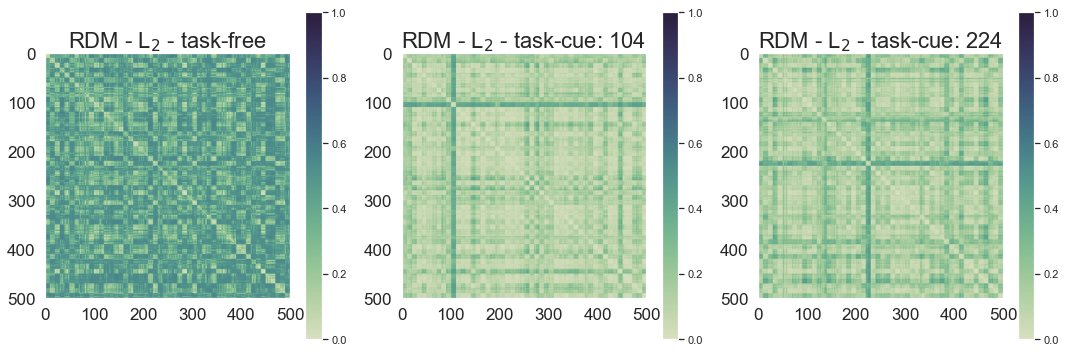

In [9]:
# Visualizing the task-free and task-dependent RDMs for L2. 
# Visualizing how the representations change when task modulations are turned on

n_examples = 200000
cat_sel_att1 = 105
cat_sel_att2 = 225

figure(figsize=(20,10))

batch_xst, batch_yst, batch_ystc1, batch_ystc2 = get_batch(n_examples,mode_h,cat_sel,lay_sel,n_perms,perm_mnist,'test')
batch_xst = mod_images_normal(batch_xst)
act_h1,act_h2 = sess.run([x_mod,h_fc1_drop], feed_dict={b_flag: 1., g_flag: 1.,
                                                             x: batch_xst, y_: batch_yst, y_c1: 0.*batch_ystc1,
                                                             y_c2: 0.*batch_ystc2, keep_prob: 1.})

avg_act1 = np.zeros([10*n_perms+1,28*28])
count_act1 = np.zeros([10*n_perms+1,1])
avg_act2 = np.zeros([10*n_perms+1,n_hl1])
count_act2 = np.zeros([10*n_perms+1,1])
for i in np.arange(n_examples/2):
    avg_act1[np.where(batch_ystc1[i,:])[0][0],:] += act_h1[i,:]
    count_act1[np.where(batch_ystc1[i,:])[0][0],:] += 1
    avg_act2[np.where(batch_ystc1[i,:])[0][0],:] += act_h2[i,:]
    count_act2[np.where(batch_ystc1[i,:])[0][0],:] += 1
avg_act1 = avg_act1/count_act1
avg_act2 = avg_act2/count_act2

rdm_act1 = (1.-np.corrcoef(avg_act1[:-1,:]))/2
rdm_act2 = (1.-np.corrcoef(avg_act2[:-1,:]))/2

pca1 = PCA(n_components=10)
pca1.fit(avg_act1[:-1,:]) 
avg_act1_t = pca1.transform(avg_act1[:-1,:])
pca2 = PCA(n_components=10)
pca2.fit(avg_act2[:-1,:]) 
avg_act2_t = pca2.transform(avg_act2[:-1,:])
pca12 = PCA(n_components=10)
pca12.fit(avg_act1[10:-1,:]) 
avg_act12_t = pca1.transform(avg_act1[10:-1,:])
pca22 = PCA(n_components=10)
pca22.fit(avg_act2[10:-1,:]) 
avg_act22_t = pca2.transform(avg_act2[10:-1,:])

subplot(2,4,1)
grid('off')
imshow(rdm_act2,cmap=map1)
rdm_act2_task_free = rdm_act2.copy()
clim([0,1])
grid('off')
colorbar()
title('RDM_L2_task-free',fontsize=16)
subplot(2,4,2)
grid('off')
plot(pca2.explained_variance_ratio_)
ylabel('% variance expl.',fontsize=16)
xlabel('PC #',fontsize=16)
ylim([-0.1,1])
print('L2, PC1, var expl: ',pca2.explained_variance_ratio_[0])
subplot(2,4,3)
grid('off')
hold('on');
plot(avg_act2_t[:10,0],avg_act2_t[:10,1],'bo', label='MNIST');
plot(avg_act2_t[10:,0],avg_act2_t[10:,1],'ko', label='Rest');
plot(avg_act2_t[cat_sel_att1,0],avg_act2_t[cat_sel_att1,1],'rd',markersize=10, label='Relv_task');
hold('off');
title('All tasks',fontsize=16)
xlabel('PC1',fontsize=16)
ylabel('PC2',fontsize=16)
legend(fontsize=16)
subplot(2,4,4)
grid('off')
hold('on');
plot(avg_act22_t[:,0],avg_act22_t[:,1],'ko');
plot(avg_act22_t[cat_sel_att1-10,0],avg_act22_t[cat_sel_att1-10,1],'rd',markersize=10);
hold('off');
title('All tasks except MNIST',fontsize=16)
xlabel('PC1',fontsize=16)
ylabel('PC2',fontsize=16)


batch_ystc2 = 0.*batch_ystc2
batch_ystc2[:,cat_sel_att1] = 1.
act_h1,act_h2 = sess.run([x_mod,h_fc1_drop], feed_dict={b_flag: 1., g_flag: 1.,
                                                             x: batch_xst, y_: batch_yst, y_c1: batch_ystc2,
                                                             y_c2: batch_ystc2, keep_prob: 1.})

avg_act1 = np.zeros([10*n_perms+1,28*28])
count_act1 = np.zeros([10*n_perms+1,1])
avg_act2 = np.zeros([10*n_perms+1,n_hl1])
count_act2 = np.zeros([10*n_perms+1,1])
for i in np.arange(n_examples/2):
    avg_act1[np.where(batch_ystc1[i,:])[0][0],:] += act_h1[i,:]
    count_act1[np.where(batch_ystc1[i,:])[0][0],:] += 1
    avg_act2[np.where(batch_ystc1[i,:])[0][0],:] += act_h2[i,:]
    count_act2[np.where(batch_ystc1[i,:])[0][0],:] += 1
avg_act1 = avg_act1/count_act1
avg_act2 = avg_act2/count_act2

rdm_act1 = (1.-np.corrcoef(avg_act1[:-1,:]))/2
rdm_act2 = (1.-np.corrcoef(avg_act2[:-1,:]))/2

pca1 = PCA(n_components=10)
pca1.fit(avg_act1[:-1,:]) 
avg_act1_t = pca1.transform(avg_act1[:-1,:])
pca2 = PCA(n_components=10)
pca2.fit(avg_act2[:-1,:]) 
avg_act2_t = pca2.transform(avg_act2[:-1,:])
pca12 = PCA(n_components=10)
pca12.fit(avg_act1[10:-1,:]) 
avg_act12_t = pca1.transform(avg_act1[10:-1,:])
pca22 = PCA(n_components=10)
pca22.fit(avg_act2[10:-1,:]) 
avg_act22_t = pca2.transform(avg_act2[10:-1,:])

subplot(2,4,5)
grid('off')
imshow(rdm_act2,cmap=map1)
rdm_act2_task_cue = rdm_act2.copy()
clim([0,1])
grid('off')
colorbar()
title('RDM_L2_task',fontsize=16)
subplot(2,4,6)
grid('off')
plot(pca2.explained_variance_ratio_)
ylabel('% variance expl.',fontsize=16)
xlabel('PC #',fontsize=16)
ylim([-0.1,1])
print('L2, PC1, var expl: ',pca2.explained_variance_ratio_[0])
subplot(2,4,7)
grid('off')
hold('on');
plot(avg_act2_t[:10,0],avg_act2_t[:10,1],'bo', label='MNIST');
plot(avg_act2_t[10:,0],avg_act2_t[10:,1],'ko', label='Rest');
plot(avg_act2_t[cat_sel_att1,0],avg_act2_t[cat_sel_att1,1],'rd',markersize=10, label='Relv_task');
hold('off');
title('All tasks',fontsize=16)
xlabel('PC1',fontsize=16)
ylabel('PC2',fontsize=16)
legend(fontsize=16)
subplot(2,4,8)
grid('off')
hold('on');
plot(avg_act22_t[:,0],avg_act22_t[:,1],'ko');
plot(avg_act22_t[cat_sel_att1-10,0],avg_act22_t[cat_sel_att1-10,1],'rd',markersize=10);
hold('off');
title('All tasks except MNIST',fontsize=16)
xlabel('PC1',fontsize=16)
ylabel('PC2',fontsize=16)

tight_layout()

batch_ystc2 = 0.*batch_ystc2
batch_ystc2[:,cat_sel_att2] = 1.
act_h1,act_h2 = sess.run([x_mod,h_fc1_drop], feed_dict={b_flag: 1., g_flag: 1.,
                                                             x: batch_xst, y_: batch_yst, y_c1: batch_ystc2,
                                                             y_c2: batch_ystc2, keep_prob: 1.})

avg_act1 = np.zeros([10*n_perms+1,28*28])
count_act1 = np.zeros([10*n_perms+1,1])
avg_act2 = np.zeros([10*n_perms+1,n_hl1])
count_act2 = np.zeros([10*n_perms+1,1])
for i in np.arange(n_examples/2):
    avg_act1[np.where(batch_ystc1[i,:])[0][0],:] += act_h1[i,:]
    count_act1[np.where(batch_ystc1[i,:])[0][0],:] += 1
    avg_act2[np.where(batch_ystc1[i,:])[0][0],:] += act_h2[i,:]
    count_act2[np.where(batch_ystc1[i,:])[0][0],:] += 1
avg_act1 = avg_act1/count_act1
avg_act2 = avg_act2/count_act2

rdm_act1 = (1.-np.corrcoef(avg_act1[:-1,:]))/2
rdm_act2 = (1.-np.corrcoef(avg_act2[:-1,:]))/2
rdm_act2_task_cue2 = rdm_act2.copy()

figure(figsize=(15,5))
subplot(1,3,1)
grid('off')
imshow(rdm_act2_task_free,cmap=map1, interpolation="hanning")
clim([0,1])
grid('off')
colorbar()
title('RDM - L$_2$ - task-free',fontsize=22)
xticks(fontsize=17)
yticks(fontsize=17)
print('avg_dissim-free,'+str(cat_sel_att1-1)+' : ',(np.sum(rdm_act2_task_free[cat_sel_att1,:])-rdm_act2_task_free[cat_sel_att1,cat_sel_att1])/(n_perms*10.-1.))
print('avg_dissim-free,'+str(cat_sel_att2-1)+' : ',(np.sum(rdm_act2_task_free[cat_sel_att2,:])-rdm_act2_task_free[cat_sel_att2,cat_sel_att2])/(n_perms*10.-1.))
subplot(1,3,2)
imshow(rdm_act2_task_cue,cmap=map1, interpolation="hanning")
clim([0,1])
grid('off')
colorbar()
title('RDM - L$_2$ - task-cue: '+str(cat_sel_att1-1),fontsize=22)
xticks(fontsize=17)
yticks(fontsize=17)
print('avg_dissim-'+str(cat_sel_att1-1)+', '+str(cat_sel_att1-1)+': ',(np.sum(rdm_act2_task_cue[cat_sel_att1,:])-rdm_act2_task_cue[cat_sel_att1,cat_sel_att1])/(n_perms*10.-1.))
print('avg_dissim-'+str(cat_sel_att1-1)+', '+str(cat_sel_att2-1)+': ',(np.sum(rdm_act2_task_cue[cat_sel_att2,:])-rdm_act2_task_cue[cat_sel_att2,cat_sel_att2])/(n_perms*10.-1.))
subplot(1,3,3)
imshow(rdm_act2_task_cue2,cmap=map1, interpolation="hanning")
clim([0,1])
grid('off')
colorbar()
title('RDM - L$_2$ - task-cue: '+str(cat_sel_att2-1),fontsize=22)
xticks(fontsize=17)
yticks(fontsize=17)
print('avg_dissim-'+str(cat_sel_att2-1)+', '+str(cat_sel_att1-1)+': ',(np.sum(rdm_act2_task_cue[cat_sel_att1,:])-rdm_act2_task_cue[cat_sel_att1,cat_sel_att1])/(n_perms*10.-1.))
print('avg_dissim-'+str(cat_sel_att2-1)+', '+str(cat_sel_att2-1)+': ',(np.sum(rdm_act2_task_cue[cat_sel_att2,:])-rdm_act2_task_cue[cat_sel_att2,cat_sel_att2])/(n_perms*10.-1.))
tight_layout()
#plt.savefig('repr_sharpening_perm_mnist.png', dpi = 300,bbox_inches='tight')

### MNIST occupies its own space because we introduced scaling as one of the augmentations while training. Scaling assumes that points next to each other are related, but that is not true for the permutations of MNIST, which makes those tasks harder than normal MNIST, which is also reflected in the observation that MNIST is represented more in L2 even in the task-free case!

### Additional possible and relevant analysis - Following Cukur, Nishimoto, Huth, & Gallant, 2013, on the application of a particular task modulation, the representational space occupied by the exemplars of that object might increase as compared with when some other object is of interest!

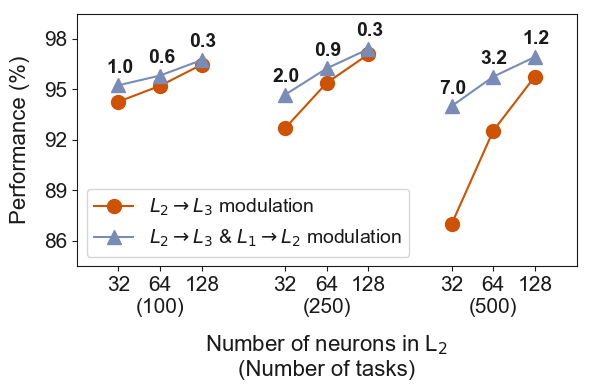

In [10]:
# Final results figure
matplotlib.rcdefaults()
csfont = {'fontname':'Arial'}
csfont = {'fontname':'Arial'}
font = {'family' : 'Arial'}
matplotlib.rc('font', **font)

t = np.array([1,2,3,5,6,7,9,10,11])
t_actual = [32,'64\n(100)',128,32,'64\n(250)',128,32,'64\n(500)',128]
data1 = np.array([0.97,0.61,0.27,1.99,0.86,0.31,7.0,3.21,1.16]) # Perf boost
data2 = np.array([94.27,95.21,96.47,92.69,95.38,97.08,87.0,92.54,95.76]) # L2 -> L3 modulation only perf

data3 = np.array([43.42,44.2,46.53,37.83,46.74,36.47,42.2,46.42,46.55,40.83,47.0,30.6,41.29,44.93,44.64,45.04,47.66,41.14]) # Perf loss after g ablation - for each NN
data4 = np.array([2.58,4.0,1.19,3.33,0.52,3.95,5.43,3.83,2.94,5.33,1.26,6.96,6.06,6.09,3.39,5.30,1.44,6.55]) # Perf loss after b ablation - for each NN

figure(figsize=(6,4))

color1 = [121./255.,140./255.,183./255.] 
color2 = [205./255.,82./255.,1./255.]
ylabel("Performance (%)", fontsize =16, labelpad=10,**csfont)
hold('on')
plot(t[6:9], 0*(data1[6:9]+data2[6:9]), 'o-',color=color2,MarkerSize=10)
plot(t[6:9], 0*(data1[6:9]+data2[6:9]), '^-',color=color1,MarkerSize=10)
for i in range(np.size(t)):
    text(t[i]-0.3,data1[i]+data2[i]+0.75,str("%.1f" % data1[i]), fontsize =14,weight='bold')
plot(t[0:3], data2[0:3], 'o-', color=color2,MarkerSize=10)
plot(t[3:6], data2[3:6], 'o-', color=color2,MarkerSize=10)
plot(t[6:9], data2[6:9], 'o-', color=color2,MarkerSize=10)
plot(t[0:3], data1[0:3]+data2[0:3], '^-', color=color1,MarkerSize=10)
plot(t[3:6], data1[3:6]+data2[3:6], '^-',color=color1,MarkerSize=10)
plot(t[6:9], data1[6:9]+data2[6:9], '^-',color=color1,MarkerSize=10)
ylim([84.5,99.5])
xlabel('Number of neurons in L$_2$\n(Number of tasks)', fontsize =16, labelpad=10,**csfont)
xticks(t,t_actual)
legend([r'$L_2\rightarrow L_3$'' modulation',r'$L_2\rightarrow L_3$ & $L_1\rightarrow L_2$'' modulation'],loc='lower left', fontsize =14)
ax = plt.axes()
ax.set_facecolor('white')
ax.tick_params(axis ='both',direction='out',labelsize=15)
grid('off')
yticks(np.arange(86, 99, 3.0))
xlim([0,12])
#text(.75,97,'A',fontsize=16,fontweight='bold')

tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('main_results_perm_mnist.png', dpi = 300,bbox_inches='tight')
